In [1]:
# Extract the dataset
!bzip2 -ckd "/content/drive/MyDrive/Datasets/5G Network Performance/clean_data.csv.bz2" > clean_data.csv

In [2]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras import Sequential, Model

In [3]:
# Configure Pandas to show all columns
pd.set_option('display.max_columns', None)

In [21]:
df = pd.read_csv('clean_data.csv')
df.head()

,time,Convert_time,DATES,TIME,DAY,YEAR,MONTH,DATE,HOUR,MIN,SEC,latitude,longitude,svr1,svr2,svr3,svr4,upload_transfer_size_mbytes,upload_bitrate_mbits/sec,download_transfer_size_rx_mbytes,download_bitrate_rx_mbits/sec,application_data,square_id
0,1656877417,2022-07-04 05:43:37,2022-07-04,05:43:37,Monday,2022,7,4,5,43,37,-37.712603,144.859029,23.0,24.4,28.4,49.8,1.91,16.10,0.840820,7.06,0.005067,square_111669149772
1,1656877418,2022-07-04 05:43:38,2022-07-04,05:43:38,Monday,2022,7,4,5,43,38,-37.712627,144.859119,43.2,47.0,44.0,55.2,1.85,15.50,0.864258,7.25,0.005664,square_111669149772
2,1656877419,2022-07-04 05:43:39,2022-07-04,05:43:39,Monday,2022,7,4,5,43,39,-37.712695,144.859188,57.0,54.8,47.2,69.1,1.91,16.10,0.947266,7.95,0.004143,square_111669149772
3,1656877424,2022-07-04 05:43:44,2022-07-04,05:43:44,Monday,2022,7,4,5,43,44,-37.712993,144.859051,27.7,34.8,36.1,44.5,1.11,9.33,1.270000,10.70,0.007172,square_111669149772
4,1656877425,2022-07-04 05:43:45,2022-07-04,05:43:45,Monday,2022,7,4,5,43,45,-37.713143,144.859034,26.0,23.1,21.4,44.4,1.48,12.40,1.690000,14.20,0.004509,square_111669149772


In [22]:
# Remove unnecessary columns
df.drop(columns=['time', 'DATES', 'TIME', 'DAY', 'YEAR', 'latitude', 'longitude', 'application_data', 'square_id'], inplace=True)

# Rename columns
df.rename(columns={
    'Convert_time': 'Date Time',
    'MONTH': 'Month',
    'DATE': 'Day',
    'HOUR': 'Hour',
    'MIN': 'Minute',
    'SEC': 'Second',
    'svr1': 'Server Latency 1',
    'svr2': 'Server Latency 2',
    'svr3': 'Server Latency 3',
    'svr4': 'Server Latency 4',
    'upload_transfer_size_mbytes': 'Upload Transfer Size',
    'upload_bitrate_mbits/sec': 'Upload Bitrate',
    'download_transfer_size_rx_mbytes': 'Download Transfer Size',
    'download_bitrate_rx_mbits/sec': 'Download Bitrate'
}, inplace=True)
df.head()

,Date Time,Month,Day,Hour,Minute,Second,Server Latency 1,Server Latency 2,Server Latency 3,Server Latency 4,Upload Transfer Size,Upload Bitrate,Download Transfer Size,Download Bitrate
0,2022-07-04 05:43:37,7,4,5,43,37,23.0,24.4,28.4,49.8,1.91,16.10,0.840820,7.06
1,2022-07-04 05:43:38,7,4,5,43,38,43.2,47.0,44.0,55.2,1.85,15.50,0.864258,7.25
2,2022-07-04 05:43:39,7,4,5,43,39,57.0,54.8,47.2,69.1,1.91,16.10,0.947266,7.95
3,2022-07-04 05:43:44,7,4,5,43,44,27.7,34.8,36.1,44.5,1.11,9.33,1.270000,10.70
4,2022-07-04 05:43:45,7,4,5,43,45,26.0,23.1,21.4,44.4,1.48,12.40,1.690000,14.20


In [23]:
# Interpolate missing values
nan_features = [
    'Server Latency 1',
    'Server Latency 2',
    'Server Latency 3',
    'Server Latency 4',
    'Upload Transfer Size',
    'Upload Bitrate',
    'Download Transfer Size',
    'Download Bitrate'
]

for feature in nan_features:
  df[feature] = df[feature].replace(0, np.nan)

df.dropna(inplace=True)

In [24]:
# Encode cyclical features with sine and cosine
months_in_year = 12
df['Month (Sin)'] = np.sin(2 * np.pi * df['Month'] / months_in_year)
df['Month (Cos)'] = np.cos(2 * np.pi * df['Month'] / months_in_year)

days_in_month = 30
df['Day (Sin)'] = np.sin(2 * np.pi * df['Day'] / days_in_month)
df['Day (Cos)'] = np.cos(2 * np.pi * df['Day'] / days_in_month)

hours_in_day = 24
df['Hour (Sin)'] = np.sin(2 * np.pi * df['Hour'] / hours_in_day)
df['Hour (Cos)'] = np.cos(2 * np.pi * df['Hour'] / hours_in_day)

minutes_in_hour = 60
df['Minute (Sin)'] = np.sin(2 * np.pi * df['Minute'] / minutes_in_hour)
df['Minute (Cos)'] = np.cos(2 * np.pi * df['Minute'] / minutes_in_hour)

seconds_in_hour = 60
df['Second (Sin)'] = np.sin(2 * np.pi * df['Second'] / seconds_in_hour)
df['Second (Cos)'] = np.cos(2 * np.pi * df['Second'] / seconds_in_hour)

# Remove unused time features
df.drop(columns=['Month', 'Day', 'Hour', 'Minute', 'Second'], inplace=True)
df.head()

,Date Time,Server Latency 1,Server Latency 2,Server Latency 3,Server Latency 4,Upload Transfer Size,Upload Bitrate,Download Transfer Size,Download Bitrate,Month (Sin),Month (Cos),Day (Sin),Day (Cos),Hour (Sin),Hour (Cos),Minute (Sin),Minute (Cos),Second (Sin),Second (Cos)
0,2022-07-04 05:43:37,23.0,24.4,28.4,49.8,1.91,16.10,0.840820,7.06,-0.5,-0.866025,0.743145,0.669131,0.965926,0.258819,-0.978148,-0.207912,-0.669131,-7.431448e-01
1,2022-07-04 05:43:38,43.2,47.0,44.0,55.2,1.85,15.50,0.864258,7.25,-0.5,-0.866025,0.743145,0.669131,0.965926,0.258819,-0.978148,-0.207912,-0.743145,-6.691306e-01
2,2022-07-04 05:43:39,57.0,54.8,47.2,69.1,1.91,16.10,0.947266,7.95,-0.5,-0.866025,0.743145,0.669131,0.965926,0.258819,-0.978148,-0.207912,-0.809017,-5.877853e-01
3,2022-07-04 05:43:44,27.7,34.8,36.1,44.5,1.11,9.33,1.270000,10.70,-0.5,-0.866025,0.743145,0.669131,0.965926,0.258819,-0.978148,-0.207912,-0.994522,-1.045285e-01
4,2022-07-04 05:43:45,26.0,23.1,21.4,44.4,1.48,12.40,1.690000,14.20,-0.5,-0.866025,0.743145,0.669131,0.965926,0.258819,-0.978148,-0.207912,-1.000000,-1.836970e-16


In [25]:
df = df.groupby('Date Time').agg('mean')
df.head()

,Server Latency 1,Server Latency 2,Server Latency 3,Server Latency 4,Upload Transfer Size,Upload Bitrate,Download Transfer Size,Download Bitrate,Month (Sin),Month (Cos),Day (Sin),Day (Cos),Hour (Sin),Hour (Cos),Minute (Sin),Minute (Cos),Second (Sin),Second (Cos)
Date Time,,,,,,,,,,,,,,,,,,
2022-07-04 05:31:55,17.4,14.4,152.0,36.4,0.328125,2.75,1.02,8.58,-0.5,-0.866025,0.743145,0.669131,0.965926,0.258819,-0.104528,-0.994522,-0.500000,0.866025
2022-07-04 05:31:56,29.3,27.2,148.0,38.1,0.520508,4.37,1.06,8.91,-0.5,-0.866025,0.743145,0.669131,0.965926,0.258819,-0.104528,-0.994522,-0.406737,0.913545
2022-07-04 05:31:57,18.8,28.4,154.0,44.0,0.520508,4.37,1.05,8.78,-0.5,-0.866025,0.743145,0.669131,0.965926,0.258819,-0.104528,-0.994522,-0.309017,0.951057
2022-07-04 05:31:58,23.6,31.6,156.0,48.4,0.780273,6.55,1.04,8.71,-0.5,-0.866025,0.743145,0.669131,0.965926,0.258819,-0.104528,-0.994522,-0.207912,0.978148
2022-07-04 05:32:00,24.1,40.2,164.0,64.7,1.110000,9.33,1.04,8.76,-0.5,-0.866025,0.743145,0.669131,0.965926,0.258819,-0.207912,-0.978148,0.000000,1.000000


In [26]:
# Compute composite features
df['Average Server Latency'] = df[['Server Latency 1', 'Server Latency 2', 'Server Latency 3', 'Server Latency 4']].mean(axis=1)
df['Total Throughput'] = df[['Upload Bitrate', 'Download Bitrate']].sum(axis=1)
df.head()

,Server Latency 1,Server Latency 2,Server Latency 3,Server Latency 4,Upload Transfer Size,Upload Bitrate,Download Transfer Size,Download Bitrate,Month (Sin),Month (Cos),Day (Sin),Day (Cos),Hour (Sin),Hour (Cos),Minute (Sin),Minute (Cos),Second (Sin),Second (Cos),Average Server Latency,Total Throughput
Date Time,,,,,,,,,,,,,,,,,,,,
2022-07-04 05:31:55,17.4,14.4,152.0,36.4,0.328125,2.75,1.02,8.58,-0.5,-0.866025,0.743145,0.669131,0.965926,0.258819,-0.104528,-0.994522,-0.500000,0.866025,55.05,11.33
2022-07-04 05:31:56,29.3,27.2,148.0,38.1,0.520508,4.37,1.06,8.91,-0.5,-0.866025,0.743145,0.669131,0.965926,0.258819,-0.104528,-0.994522,-0.406737,0.913545,60.65,13.28
2022-07-04 05:31:57,18.8,28.4,154.0,44.0,0.520508,4.37,1.05,8.78,-0.5,-0.866025,0.743145,0.669131,0.965926,0.258819,-0.104528,-0.994522,-0.309017,0.951057,61.30,13.15
2022-07-04 05:31:58,23.6,31.6,156.0,48.4,0.780273,6.55,1.04,8.71,-0.5,-0.866025,0.743145,0.669131,0.965926,0.258819,-0.104528,-0.994522,-0.207912,0.978148,64.90,15.26
2022-07-04 05:32:00,24.1,40.2,164.0,64.7,1.110000,9.33,1.04,8.76,-0.5,-0.866025,0.743145,0.669131,0.965926,0.258819,-0.207912,-0.978148,0.000000,1.000000,73.25,18.09


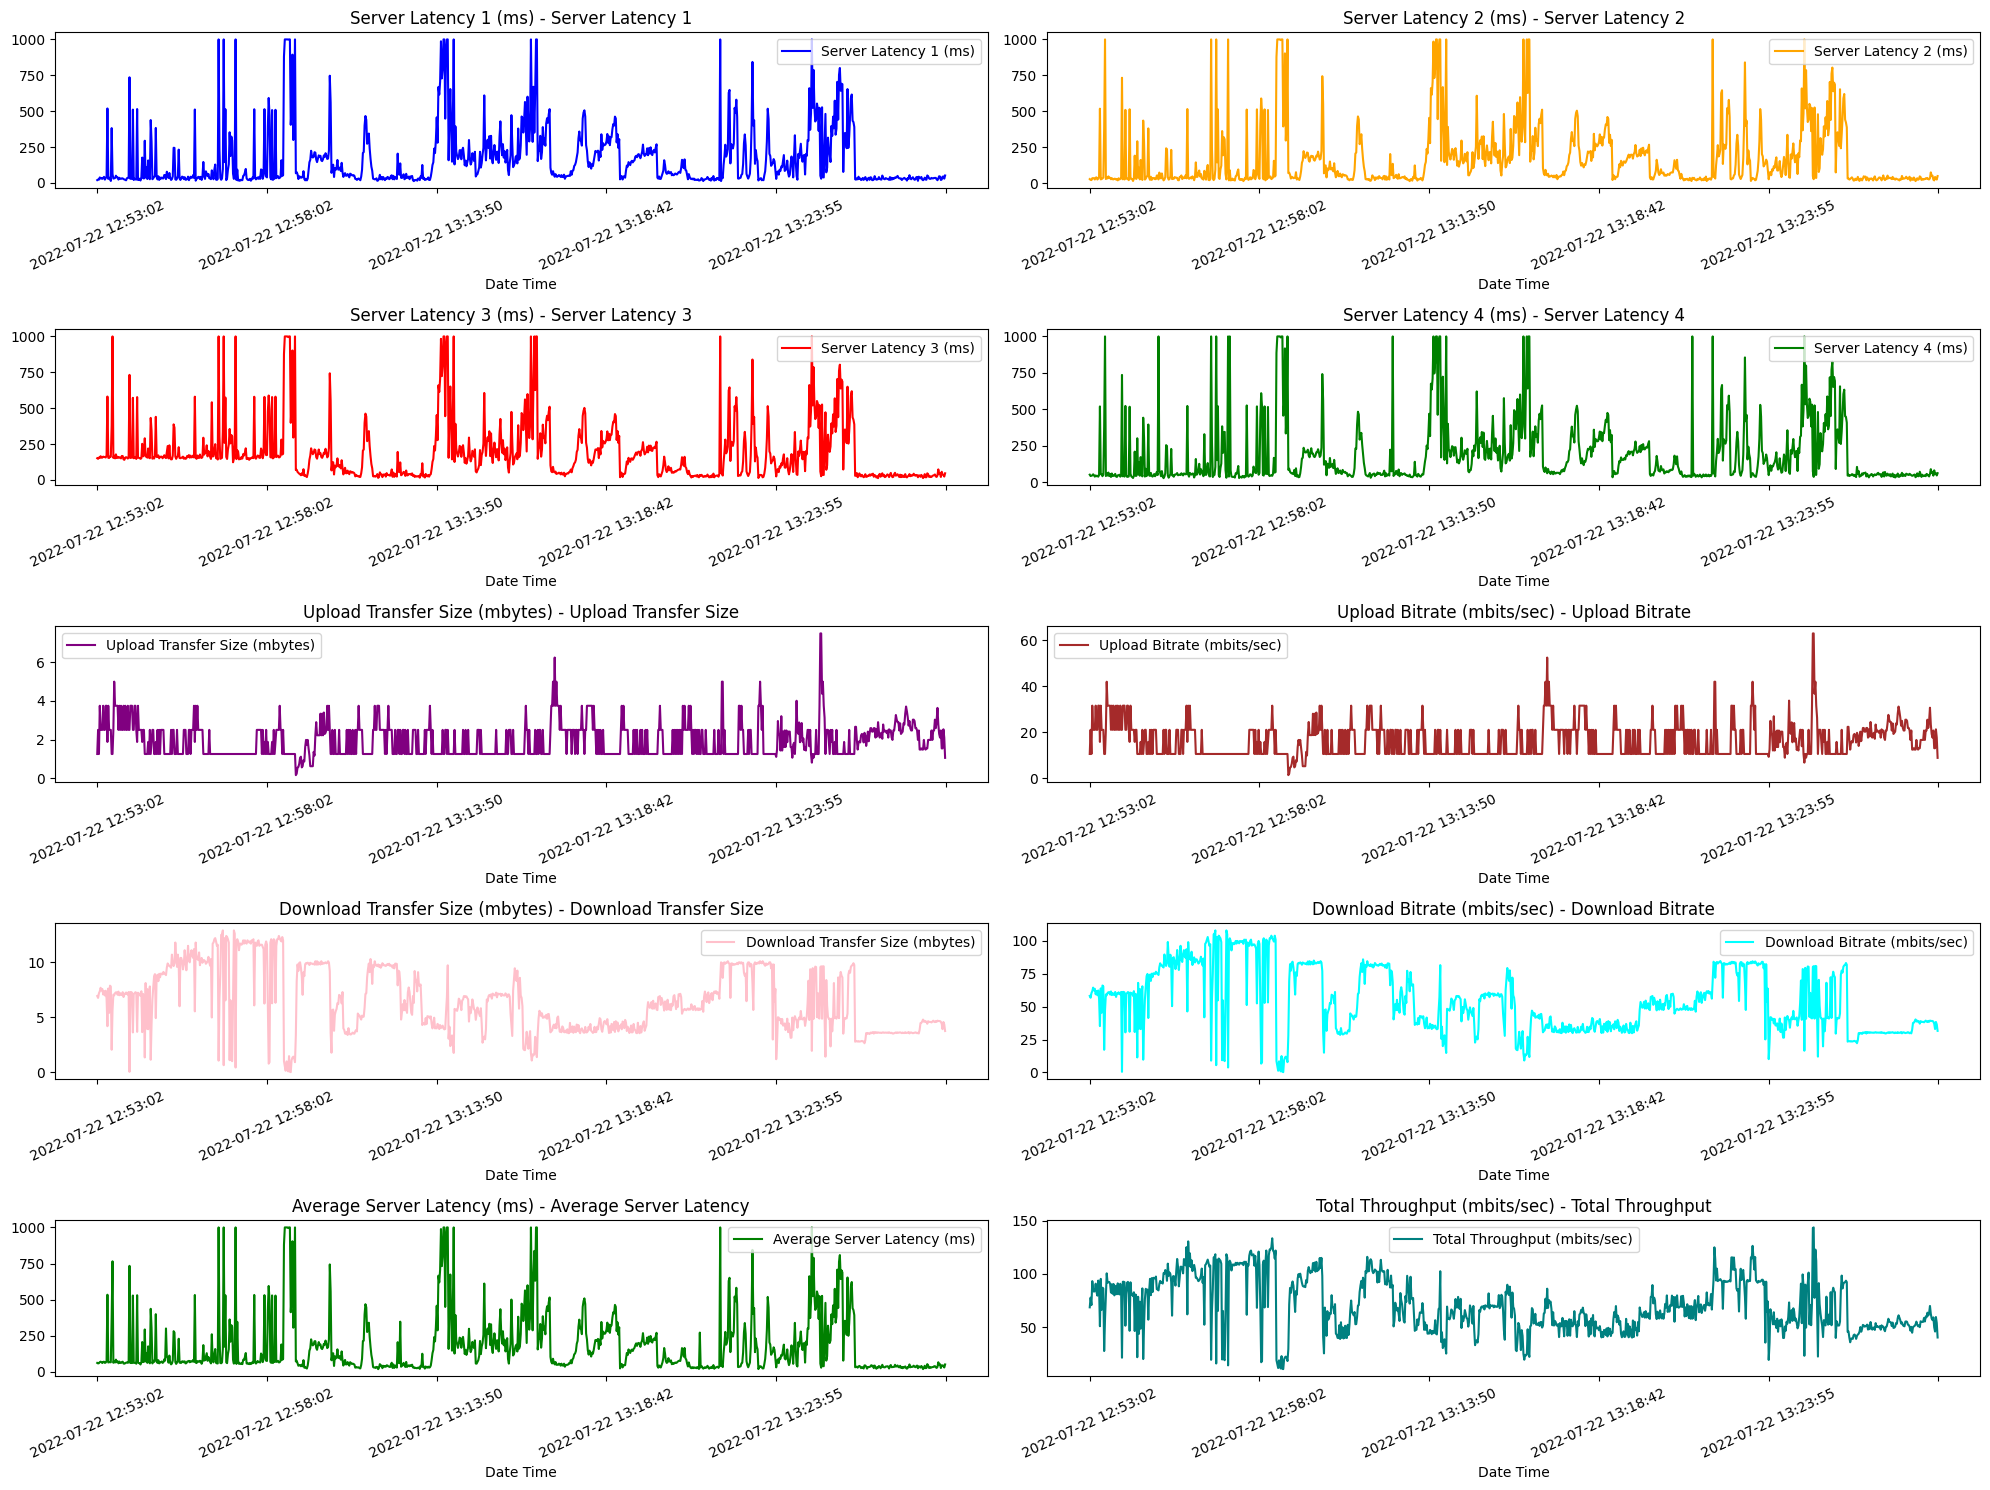

In [29]:
# Visualise timeseries data
features = [
    ('Server Latency 1', 'Server Latency 1 (ms)', 'blue'),
    ('Server Latency 2', 'Server Latency 2 (ms)', 'orange'),
    ('Server Latency 3', 'Server Latency 3 (ms)', 'red'),
    ('Server Latency 4', 'Server Latency 4 (ms)', 'green'),
    ('Upload Transfer Size', 'Upload Transfer Size (mbytes)', 'purple'),
    ('Upload Bitrate', 'Upload Bitrate (mbits/sec)', 'brown'),
    ('Download Transfer Size', 'Download Transfer Size (mbytes)', 'pink'),
    ('Download Bitrate', 'Download Bitrate (mbits/sec)', 'cyan'),
    ('Average Server Latency', 'Average Server Latency (ms)', 'green'),
    ('Total Throughput', 'Total Throughput (mbits/sec)', 'teal'),
]

def visualise_data(data):
    fig, axes = plt.subplots(
        nrows=5, ncols=2, figsize=(20, 15)
    )

    for i in range(len(features)):
        key, title, color = features[i]
        t_data = data[key].tail(1000)
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=color,
            title="{} - {}".format(title, key),
            rot=25
        )

        ax.legend([title])

    plt.tight_layout()

visualise_data(df)

In [30]:
# Resample points to be per hour instead of per second
sampling_rate = 60 * 60

train_size = 0.7
train_split = int(train_size * int(df.shape[0]))

# The model is shown data from the past 12 hours
past = 12 * 60 * 60
future = 60 * 60
batch_size = 256
epochs = 10

In [31]:
selected_features = [
    'Month (Sin)',
    'Month (Cos)',
    'Day (Sin)',
    'Day (Cos)',
    'Hour (Sin)',
    'Hour (Cos)',
    'Minute (Sin)',
    'Minute (Cos)',
    'Second (Sin)',
    'Second (Cos)',
    'Average Server Latency',
    'Total Throughput'
]

features = df[selected_features]
features.head()

,Month (Sin),Month (Cos),Day (Sin),Day (Cos),Hour (Sin),Hour (Cos),Minute (Sin),Minute (Cos),Second (Sin),Second (Cos),Average Server Latency,Total Throughput
Date Time,,,,,,,,,,,,
2022-07-04 05:31:55,-0.5,-0.866025,0.743145,0.669131,0.965926,0.258819,-0.104528,-0.994522,-0.500000,0.866025,55.05,11.33
2022-07-04 05:31:56,-0.5,-0.866025,0.743145,0.669131,0.965926,0.258819,-0.104528,-0.994522,-0.406737,0.913545,60.65,13.28
2022-07-04 05:31:57,-0.5,-0.866025,0.743145,0.669131,0.965926,0.258819,-0.104528,-0.994522,-0.309017,0.951057,61.30,13.15
2022-07-04 05:31:58,-0.5,-0.866025,0.743145,0.669131,0.965926,0.258819,-0.104528,-0.994522,-0.207912,0.978148,64.90,15.26
2022-07-04 05:32:00,-0.5,-0.866025,0.743145,0.669131,0.965926,0.258819,-0.207912,-0.978148,0.000000,1.000000,73.25,18.09


In [32]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.00001,-0.961993,0.334255,1.561282,0.891856,1.99252,-0.137246,-1.407165,-0.706786,1.225081,-0.505589,-1.486087
1,1.00001,-0.961993,0.334255,1.561282,0.891856,1.99252,-0.137246,-1.407165,-0.574899,1.292289,-0.463001,-1.376427
2,1.00001,-0.961993,0.334255,1.561282,0.891856,1.99252,-0.137246,-1.407165,-0.436710,1.345340,-0.458057,-1.383738
3,1.00001,-0.961993,0.334255,1.561282,0.891856,1.99252,-0.137246,-1.407165,-0.293733,1.383655,-0.430679,-1.265080
4,1.00001,-0.961993,0.334255,1.561282,0.891856,1.99252,-0.282998,-1.383934,0.000283,1.414560,-0.367178,-1.105932


In [33]:
train_data = features.loc[0:train_split - 1]
val_data = features.loc[train_split:]

In [34]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(len(selected_features))]].values
y_train = features.iloc[start:end][[11]]

sequence_length = int(past / sampling_rate)

In [35]:
training_dataset = timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size
)

In [36]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_validation = val_data.iloc[:x_end][[i for i in range(len(selected_features))]].values
y_validation = features.iloc[label_start:][[11]]

validation_dataset = timeseries_dataset_from_array(
    x_validation,
    y_validation,
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size
)

In [37]:
for batch in validation_dataset.take(1):
    inputs, targets = batch

print("Input shape:", inputs.shape)
print("Target shape:", targets.shape)

Input shape: (256, 12, 12)
Target shape: (256, 1)


In [38]:
# Build the LSTM model
inputs = Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = LSTM(32)(inputs)
outputs = Dense(1)(lstm_out)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(), loss='mse')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 12, 12)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │           5,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,793 (22.63 KB)

 Trainable params: 5,793 (22.63 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
history = model.fit(
    training_dataset,
    epochs=epochs,
    validation_data=validation_dataset
)

Epoch 1/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 39s 38ms/step - loss: 1.0374 - val_loss: 1.2438
Epoch 2/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - loss: 0.8687 - val_loss: 1.1958
Epoch 3/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - loss: 0.7996 - val_loss: 1.1403
Epoch 4/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - loss: 0.7977 - val_loss: 1.1242
Epoch 5/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step - loss: 0.7925 - val_loss: 1.1264
Epoch 6/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - loss: 0.7925 - val_loss: 1.1344
Epoch 7/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 34s 35ms/step - loss: 0.7462 - val_loss: 1.1483
Epoch 8/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - loss: 0.7091 - val_loss: 1.2088
Epoch 9/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - loss: 0.6882 - val_loss: 1.2624
Epoch 10/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 36s 37ms/step - loss: 0.6627 - val_loss: 1.3000


In [41]:
model.save('timeseries_model_lstm.keras')